In [1]:
import mediapipe as mp
import cv2
import numpy as np 
import uuid
import os
from matplotlib import pyplot as plt

mp_drawing=mp.solutions.drawing_utils
mp_hands=mp.solutions.hands

joint_list = [[8,6,0], [12,10,0], [16,14,0], [20,18,0],[4,2,0]] #3rd

def get_label1b(index,hand,results):
    output=None
    for idx,classification in enumerate(results.multi_handedness):
        if classification.classification[0].index==index:
            #Process results
            label=classification.classification[0].index
            score=classification.classification[0].score
            text='{} {}'.format(label,round(score,2))
            
            #Extract coordinates:
            coords=tuple(np.multiply(
                np.array((hand.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,hand.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y)),
            [640,480]).astype(int))
            
            output=text,coords
            
    return output

def get_label_index(index,hand,results):
    output=None
    for idx,classification in enumerate(results.multi_handedness):
        if classification.classification[0].index==index:
            #Process results
            label=classification.classification[0].index
            score=classification.classification[0].score
            text='{} {}'.format(label,round(score,2))
            
            #Extract coordinates:
            coords=tuple(np.multiply(
                np.array((hand.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,hand.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y)),
            [640,480]).astype(int))
            
            output=text,coords
            
    return output

In [2]:
#EXTRA-SMALL ONE
xi=[140,186,227,266,309,347,389,430,474,514,143,186,224,266,305,348,389,428,473,517,143,184,222,268,309,350,390,430,474,514,149,191,230,287,331,371,499]
yi=[81,79,82,83,83,87,83,81,82,85,139,137,137,138,136,138,137,139,140,141,199,194,191,191,192,194,196,192,194,192,252,253,251,255,257,251,252]
ltr=['q','w','e','r','t','y','u','i','o','p','a','s','d','f','g','h','j','k','l',';','z','x','c','v','b','n','m',',','.','/',' ',' ',' ',' ',' ',' ','*']
dist=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]
def find_minimum_index(arr):
    if not arr:
        return None  # Return None if the array is empty

    min_index = 0  # Assume the first element is the minimum
    for i in range(1, len(arr)):
        if arr[i] < arr[min_index]:
            min_index = i

    return min_index

def find_minmax_index(arr):
    if not arr:
        return None  # Return None if the array is empty

    min_index = 0  # Assume the first element is the minimum
    max_index = 0
    for i in range(1, len(arr)):
        if arr[i] < arr[min_index]:
            min_index = i
        if arr[i] > arr[max_index]:
            max_index = i

    return min_index,max_index

from time import sleep
def findDistance(num):
    p1x=results.multi_hand_landmarks[num].landmark[mp_hands.HandLandmark.THUMB_TIP].x
    p1y=results.multi_hand_landmarks[num].landmark[mp_hands.HandLandmark.THUMB_TIP].y
    p2x=results.multi_hand_landmarks[num].landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x
    p2y=results.multi_hand_landmarks[num].landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y
    distancey=math.sqrt(((p1x-p2x)**2)+((p1y-p2y)**2))
    return distancey

import math
mini=10000
mindex=0
def find_dis(x,y):
    mini=10000
    for i in range(len(dist)):
        dist[i]=math.sqrt(((x-xi[i])**2)+((y-yi[i])**2))
        if dist[i]<mini:
            mini=dist[i]
            mindex=i
    return mindex

In [3]:
def draw_finger_angles(image, results, joint_list,lst,lst2,x1,y1,tot1,tot2):
    
    # Loop through hands
    for hand in results.multi_hand_landmarks:
        #Loop through joint sets 
        tmp=0
        for joint in joint_list:
            a = np.array([hand.landmark[joint[0]].x, hand.landmark[joint[0]].y]) # First coord
            b = np.array([hand.landmark[joint[1]].x, hand.landmark[joint[1]].y]) # Second coord(mid pt.)
            c = np.array([hand.landmark[joint[2]].x, hand.landmark[joint[2]].y]) # Third coord
            
            radians = np.arctan2(c[1] - b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
            angle = np.abs(radians*180.0/np.pi)
            
            if angle > 180.0:
                angle = 360-angle
            if hand == results.multi_hand_landmarks[0] and tmp==0:
                x1.append(angle)
                tot1.append(angle)
            elif len(results.multi_hand_landmarks)>1 and hand == results.multi_hand_landmarks[1] and tmp==0:
                y1.append(angle)
                tot2.append(angle)
            cv2.putText(image, str(round(angle, 2)), tuple(np.multiply(b, [640, 480]).astype(int)),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            if len(x1) > 30:
                x1.pop(0)
            if len(y1) > 30:
                y1.pop(0)
            tmp+=1
    return image

In [4]:
#DTW FUNCTION:
def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

#FASTEST OVERALL
import numpy as np

def dtw(s, t, window):
    n, m = len(s), len(t)
    w = max(window, abs(n - m))
    w = max(w, abs(len(s) - len(t)))
    dtw_matrix = np.zeros((n + 1, m + 1))
    dtw_matrix[1:, 1:] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(max(1, i - w), min(m, i + w) + 1):
            cost = abs(s[i - 1] - t[j - 1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],  # insertion
                dtw_matrix[i, j - 1],  # deletion
                dtw_matrix[i - 1, j - 1]  # match/mismatch
            )

    return dtw_matrix[n, m]

In [5]:
my_dict1={0: [179.37,
  178.94,
  179.86,
  179.97,
  179.86,
  179.74,
  178.94,
  178.71,
  179.18,
  177.2,
  174.7,
  159.1,
  151.62,
  159.95,
  159.62,
  156.01,
  152.75,
  172.64,
  170.5,
  175.06,
  177.58,
  179.76,
  179.63,
  178.53,
  178.62,
  177.23,
  177.75,
  177.01,
  177.51,
  177.52],
 1: [177.27,
  176.15,
  176.73,
  177.4,
  176.76,
  176.79,
  178.51,
  179.19,
  177.35,
  170.52,
  151.72,
  151.97,
  140.9,
  156.08,
  157.04,
  159.68,
  168.09,
  162.31,
  169.32,
  173.16,
  175.06,
  179.33,
  178.9,
  177.97,
  177.22,
  177.63,
  178.46,
  178.42,
  177.93,
  178.37],
 2: [179.79,
  179.31,
  179.7,
  179.73,
  178.88,
  177.43,
  173.68,
  170.17,
  167.66,
  163.05,
  157.02,
  164.22,
  162.65,
  165.38,
  167.73,
  175.68,
  174.93,
  173.0,
  176.53,
  179.74,
  179.77,
  179.13,
  179.3,
  178.15,
  177.52,
  179.66,
  179.16,
  179.06,
  178.78,
  178.75],
 3: [179.79,
  179.31,
  179.7,
  179.73,
  178.88,
  177.43,
  173.68,
  170.17,
  167.66,
  163.05,
  157.02,
  164.22,
  162.65,
  165.38,
  167.73,
  175.68,
  174.93,
  173.0,
  176.53,
  179.74,
  179.77,
  179.13,
  179.3,
  178.15,
  177.52,
  179.66,
  179.16,
  179.06,
  178.78,
  178.75],
 4: [176.21,
  176.83,
  177.45,
  176.35,
  178.51,
  176.71,
  177.49,
  177.52,
  177.39,
  178.1,
  174.02,
  171.54,
  153.46,
  149.95,
  149.84,
  151.31,
  143.81,
  146.34,
  154.07,
  172.66,
  173.4,
  171.5,
  177.03,
  173.83,
  175.11,
  176.73,
  176.11,
  178.1,
  177.16,
  177.58]}

my_dict1b={0: [174.24,
  174.58,
  173.83,
  173.2,
  174.11,
  174.61,
  174.25,
  173.57,
  175.3,
  178.99,
  174.93,
  171.75,
  163.52,
  150.94,
  156.98,
  153.21,
  150.4,
  158.84,
  171.81,
  172.4,
  171.85,
  178.39,
  174.35,
  172.53,
  171.25,
  170.15,
  170.68,
  170.99,
  170.43,
  170.75],
 1: [172.92,
  172.29,
  172.69,
  171.55,
  173.58,
  172.76,
  172.41,
  172.94,
  172.12,
  179.36,
  173.27,
  167.98,
  159.78,
  161.19,
  162.89,
  159.71,
  163.71,
  173.03,
  172.87,
  175.24,
  175.9,
  174.43,
  172.26,
  171.85,
  171.05,
  171.25,
  170.25,
  170.4,
  169.5,
  170.72],
 2: [171.78,
  172.55,
  171.43,
  172.99,
  171.82,
  177.08,
  168.14,
  162.78,
  159.82,
  156.22,
  158.83,
  163.32,
  160.01,
  163.08,
  170.1,
  170.09,
  177.66,
  179.94,
  173.0,
  171.84,
  172.59,
  171.04,
  172.2,
  172.11,
  172.01,
  171.75,
  171.36,
  172.76,
  171.78,
  172.05],
 3: [170.75,
  170.37,
  170.53,
  171.26,
  169.52,
  171.03,
  170.71,
  175.91,
  179.18,
  170.77,
  158.56,
  154.3,
  154.74,
  150.77,
  147.9,
  150.14,
  159.97,
  163.85,
  176.02,
  170.09,
  178.95,
  179.45,
  177.45,
  172.47,
  172.18,
  171.0,
  171.63,
  169.49,
  171.56,
  171.3],
 4: [171.64,
  171.03,
  171.97,
  171.48,
  171.83,
  172.92,
  170.88,
  169.13,
  164.6,
  157.19,
  156.13,
  153.86,
  159.31,
  159.84,
  162.01,
  169.46,
  168.78,
  170.4,
  179.31,
  175.79,
  172.87,
  170.94,
  170.51,
  171.31,
  171.22,
  171.0,
  171.59,
  171.2,
  171.53,
  171.26]}

my_dict2={0: [151.65,
  151.49,
  152.82,
  153.67,
  152.39,
  151.88,
  152.97,
  155.31,
  152.58,
  150.18,
  146.47,
  149.25,
  134.11,
  136.17,
  138.86,
  136.64,
  142.54,
  139.98,
  141.7,
  144.1,
  148.87,
  151.76,
  156.8,
  156.14,
  153.65,
  156.65,
  155.83,
  156.31,
  157.19,
  156.49],
 1: [155.32,
  153.67,
  157.36,
  155.76,
  158.42,
  156.81,
  156.16,
  155.83,
  156.69,
  155.08,
  152.07,
  142.68,
  142.12,
  145.01,
  144.91,
  139.27,
  144.74,
  144.05,
  142.34,
  148.54,
  152.16,
  155.89,
  157.93,
  158.59,
  158.57,
  159.98,
  159.54,
  158.88,
  160.98,
  158.18],
 2: [157.55,
  158.52,
  157.28,
  155.7,
  155.51,
  155.87,
  158.87,
  158.03,
  153.02,
  158.17,
  154.15,
  150.92,
  146.36,
  141.53,
  140.27,
  135.68,
  134.42,
  144.25,
  145.45,
  145.19,
  144.45,
  144.29,
  149.49,
  150.8,
  156.86,
  158.94,
  159.75,
  160.77,
  158.86,
  159.19],
 3: [158.72,
  156.19,
  157.15,
  154.77,
  157.24,
  158.81,
  160.15,
  158.83,
  153.47,
  139.69,
  132.54,
  126.42,
  125.29,
  124.71,
  120.25,
  114.89,
  128.68,
  124.25,
  134.96,
  147.94,
  153.31,
  155.85,
  161.02,
  159.12,
  161.52,
  161.31,
  161.82,
  162.96,
  162.74,
  161.64],
 4: [161.51,
  160.48,
  163.33,
  160.23,
  163.1,
  158.64,
  149.12,
  140.52,
  132.48,
  120.41,
  127.49,
  132.14,
  132.93,
  142.42,
  144.93,
  149.51,
  152.96,
  158.07,
  160.79,
  163.15,
  162.99,
  164.69,
  165.77,
  164.66,
  165.27,
  165.25,
  165.02,
  163.83,
  165.17,
  164.9]}

my_dict3={0: [149.69,
  151.36,
  151.37,
  151.32,
  150.6,
  150.91,
  151.79,
  147.74,
  141.38,
  138.57,
  130.75,
  131.2,
  127.0,
  125.88,
  124.77,
  122.59,
  125.67,
  124.5,
  135.61,
  142.34,
  142.48,
  150.09,
  154.06,
  154.16,
  155.36,
  154.85,
  155.31,
  157.03,
  155.45,
  153.35],
 1: [154.19,
  154.67,
  154.18,
  155.05,
  154.36,
  153.08,
  156.09,
  153.68,
  152.82,
  146.94,
  141.73,
  129.06,
  128.18,
  122.83,
  127.79,
  122.17,
  126.19,
  131.23,
  146.12,
  153.6,
  154.96,
  157.27,
  159.7,
  159.02,
  157.88,
  157.85,
  159.88,
  157.44,
  157.07,
  158.27],
 2: [157.65,
  157.65,
  158.41,
  157.03,
  157.28,
  159.56,
  158.18,
  158.52,
  156.94,
  148.69,
  141.43,
  132.07,
  125.69,
  127.13,
  126.55,
  125.06,
  134.55,
  139.0,
  142.86,
  144.71,
  153.14,
  153.49,
  157.0,
  156.04,
  159.73,
  158.46,
  159.13,
  157.13,
  158.23,
  159.03],
 3: [158.69,
  159.19,
  160.82,
  158.8,
  159.17,
  159.91,
  157.98,
  157.03,
  146.95,
  140.08,
  126.49,
  124.42,
  127.83,
  126.74,
  128.62,
  129.63,
  130.7,
  142.14,
  145.62,
  155.09,
  155.55,
  157.21,
  157.38,
  158.51,
  159.43,
  160.67,
  160.13,
  159.66,
  160.25,
  158.22],
 4: [158.46,
  158.47,
  157.84,
  159.92,
  159.56,
  158.59,
  159.82,
  161.21,
  159.52,
  158.75,
  158.72,
  159.01,
  159.57,
  159.45,
  160.22,
  159.61,
  160.44,
  160.22,
  158.24,
  159.31,
  156.57,
  145.0,
  136.57,
  125.54,
  128.38,
  133.27,
  132.98,
  142.37,
  140.96,
  145.01]}

my_dict4={0: [134.39,
  138.52,
  137.97,
  138.17,
  139.66,
  138.64,
  139.26,
  142.94,
  141.55,
  139.92,
  133.17,
  117.08,
  112.44,
  118.56,
  115.31,
  117.53,
  126.21,
  115.27,
  123.64,
  121.99,
  127.49,
  136.24,
  142.71,
  151.58,
  153.56,
  155.2,
  156.49,
  156.83,
  157.13,
  155.23],
 1: [147.32,
  147.57,
  148.46,
  148.12,
  145.36,
  146.7,
  147.3,
  149.14,
  147.51,
  148.99,
  146.16,
  147.98,
  145.89,
  135.59,
  106.24,
  107.79,
  127.07,
  134.27,
  116.37,
  118.83,
  122.15,
  118.06,
  130.76,
  140.2,
  146.57,
  149.21,
  151.41,
  153.31,
  152.37,
  152.71],
 2: [145.5,
  146.96,
  146.5,
  147.29,
  147.2,
  144.41,
  144.04,
  147.0,
  140.02,
  122.29,
  117.28,
  122.67,
  119.53,
  125.01,
  119.07,
  124.0,
  117.79,
  126.38,
  118.94,
  121.94,
  138.22,
  138.65,
  142.1,
  147.2,
  150.4,
  151.45,
  151.78,
  153.04,
  154.62,
  153.4],
 3: [150.85,
  151.02,
  150.16,
  149.39,
  149.0,
  149.11,
  126.61,
  117.59,
  116.49,
  121.38,
  129.81,
  131.82,
  122.82,
  121.27,
  129.59,
  117.93,
  118.3,
  122.16,
  130.02,
  134.74,
  135.11,
  143.38,
  153.85,
  154.36,
  158.01,
  157.51,
  158.81,
  156.93,
  154.44,
  155.48],
 4: [147.26,
  146.95,
  145.19,
  148.24,
  147.35,
  148.65,
  148.13,
  148.74,
  148.89,
  134.71,
  119.39,
  123.21,
  115.55,
  128.18,
  116.19,
  121.13,
  124.05,
  131.46,
  136.4,
  146.77,
  154.04,
  155.53,
  156.45,
  156.65,
  155.69,
  156.47,
  157.88,
  157.16,
  156.2,
  154.86]}

In [6]:
d1=my_dict1.copy()
d2=my_dict2.copy()
d3=my_dict3.copy()
d4=my_dict4.copy()
d5=my_dict1b.copy()

In [7]:
#EXTRA-SMALL ONE
xi=[94,135,170,216,258,298,340,378,421,461,95,136,171,213,258,294,342,377,420,463,95,136,174,218,258,300,340,380,417,462,95,132,181,221,285,320,450]
yi=[110,112,115,114,117,115,117,116,122,118,168,168,171,173,173,173,172,177,176,175,224,221,224,225,228,230,230,231,233,234,280,281,282,284,285,290,285]
ltr=['q','w','e','r','t','y','u','i','o','p','a','s','d','f','g','h','j','k','l',';','z','x','c','v','b','n','m',',','.','/',' ',' ',' ',' ',' ',' ','*']
dist=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]

In [8]:
import time

angle_array100=[]
angle_array101=[]
# Initialize the array to store the angle values
angle_array10 = [0] * 30
X1 = [0] * 30
Y1 = [0] * 30

angle_array20 = [0] * 30
X2 = [0] * 30
Y2 = [0] * 30

angle_array30 = [0] * 30
X3 = [0] * 30
Y3 = [0] * 30

angle_array40 = [0] * 30
X4 = [0] * 30
Y4 = [0] * 30

angle_array11 = [0] * 30
X5 = [0] * 30
Y5 = [0] * 30

angle_array21 = [0] * 30
X6 = [0] * 30
Y6 = [0] * 30

angle_array31 = [0] * 30
X7 = [0] * 30
Y7 = [0] * 30

angle_array41 = [0] * 30
X8 = [0] * 30
Y8 = [0] * 30

ptrn=[]
flag1=False
flag2=False

cap = cv2.VideoCapture(1)
stree=""
lst=[165.00,160.00,150.00,150.00]
lst2=[165.00,160.00,150.00,150.00]

start_time = time.time()

with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7,max_num_hands=2) as hands: 
    while cap.isOpened():
        ret, frame = cap.read()
        
        # BGR 2 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Flip on horizontal
        #image = cv2.flip(image, 1)
        
        # Set flag
        image.flags.writeable = False
        
        # Detections
        results = hands.process(image)
        
        # Set flag to true
        image.flags.writeable = True
        
        # RGB 2 BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Detections
        #print(results)
        
        # Rendering results
        if results.multi_hand_landmarks:
            # Get the number of detected hands
            num_hands = len(results.multi_hand_landmarks)
            draw_finger_angles(image, results, joint_list,lst,lst2,angle_array10,angle_array11,angle_array100,angle_array101)
                
            for num, hand in enumerate(results.multi_hand_landmarks):
                mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS)
                # Draw angles to image from joint list
                #Render left or right detection
                """
                if get_label(num,hand,results):
                    text,coord=get_label(num,hand,results)
                    mindex=find_dis(coord[0],coord[1])
                    #cv2.putText(image,str(coord[0])+","+str(coord[1]),coord,cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)# font size, color,line size,line type
                """
                if get_label_index(num,hand,results):
                    text1,coord1=get_label_index(num,hand,results)
                
                    if num==0:
                        text1,coord1=get_label_index(num,hand,results)
                        #RHS
                        #index1 = find_minimum_index(angle_array10)
                        index1,index2=find_minmax_index(angle_array10)
                        #print(angle_array10)
                        #print(index1)
                        mindex1=find_dis(X1[index1],Y1[index1])
                        X1.append(coord1[0])
                        Y1.append(coord1[1])
                        #print(X1[index1])
                        if len(X1) > 30:
                            X1.pop(0)
                            Y1.pop(0)
                        #cv2.putText(image,str(coord1[0])+","+str(coord1[1]),coord1,cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)# font size, color,line size,line type
                        #print(dtw(d1[24], angle_array, 3)[-1][-1],dtw(d1[21], angle_array, 3)[-1][-1],dtw(d1[22], angle_array, 3)[-1][-1],dtw(d1[23], angle_array, 3)[-1][-1])
                        #print(dtw(d1[0], angle_array10, 3)[-1][-1],dtw(d1[1], angle_array10, 3)[-1][-1],dtw(d1[2], angle_array10, 3)[-1][-1],dtw(d1[3], angle_array10, 3)[-1][-1])
                        #print(dtw(d1[1], angle_array10, 3))
                        #if dtw(d1[0], angle_array10, 3)<130 or dtw(d1[1], angle_array10, 3)<10 or dtw(d1[2], angle_array10, 3)<10 or dtw(d1[3], angle_array10, 3)<10:
                        if flag1==False and angle_array10[index2]-angle_array10[index1]>40:
                            flag1=True
                        if flag1==True and angle_array10[index2]-angle_array10[index1]<40:
                            if ltr[mindex1]=="*":
                                stree=stree[0:-1]
                            else:
                                stree=stree+ltr[mindex1]
                            for i in range(30):
                                angle_array10[i] = 170
                                flag1=False
                            sleep(0.99)
                        
                    if num==1:
                        #LHS
                        #index1 = find_minimum_index(angle_array11)
                        index1,index2=find_minmax_index(angle_array11)
                        mindex1=find_dis(X5[index1],Y5[index1])
                        X5.append(coord1[0])
                        Y5.append(coord1[1])
                        if len(X5) > 30:
                            X5.pop(0)
                            Y5.pop(0)
                        #cv2.putText(image,str(coord1[0])+","+str(coord1[1]),coord1,cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)# font size, color,line size,line type
                        #print(dtw(d1[24], angle_array, 3)[-1][-1],dtw(d1[21], angle_array, 3)[-1][-1],dtw(d1[22], angle_array, 3)[-1][-1],dtw(d1[23], angle_array, 3)[-1][-1])
                        ##print(dtw(d1[0], angle_array11, 3),dtw(d1[1], angle_array11, 3),dtw(d1[2], angle_array11, 3),dtw(d1[3], angle_array11, 3))
                        #if dtw(d5[0], angle_array11, 3)<120 or dtw(d5[1], angle_array11, 3)<10 or dtw(d5[2], angle_array11, 3)<10 or dtw(d5[3], angle_array11, 3)<10:
                        if flag2==False and angle_array10[index2]-angle_array10[index1]>40:
                            flag2=True
                        if flag2==True and angle_array10[index2]-angle_array10[index1]<40:
                            if ltr[mindex1]=="*":
                                stree=stree[0:-1]
                            else:
                                stree=stree+ltr[mindex1]
                            for i in range(30):
                                angle_array11[i] = 170
                                flag2=False
                            sleep(0.99)
                
        # Calculate the elapsed time
        elapsed_time = int(time.time() - start_time) 
        # Draw the timer text on the image
        timer_text = f"Timer: {elapsed_time} s"
        cv2.putText(image, timer_text, (image.shape[1] - 200, image.shape[0] - 20),cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image,stree,(10,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        # Save our image    
        #cv2.imwrite(os.path.join('Output Images', '{}.jpg'.format(uuid.uuid1())), image)
        cv2.imshow('Hand Tracking', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [51]:
len(angle_array100)

672

In [41]:
len(angle_array101)

531

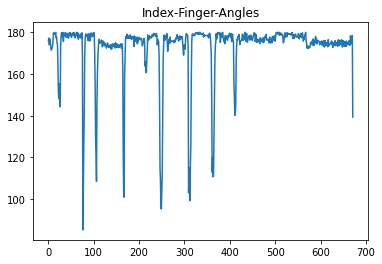

In [52]:
import matplotlib.pyplot as plt
t1=[i for i in range(len(angle_array100))]
plt.plot(t1, angle_array100)#X-Y axis
plt.title("Index-Finger-Angles")
#plt.savefig('T4a.png')
plt.show()

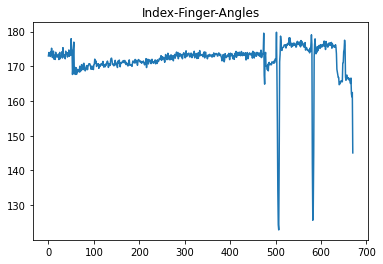

In [53]:
import matplotlib.pyplot as plt
t1=[i for i in range(len(angle_array101))]
plt.plot(t1, angle_array101)#X-Y axis
plt.title("Index-Finger-Angles")
#plt.savefig('T4b.png')
plt.show()

In [54]:
my_dict1 = {}
for i in range(5):
    my_dict1[i] = [0] * 30

In [55]:
tempo=angle_array101.copy()

In [56]:
import matplotlib.pyplot as plt
def plotgrph(a,b):
    t1=[i for i in range(len(angle_array101[a:b]))]
    plt.plot(t1, angle_array101[a:b])#X-Y axis
    plt.title("Index-Finger")
    plt.show()

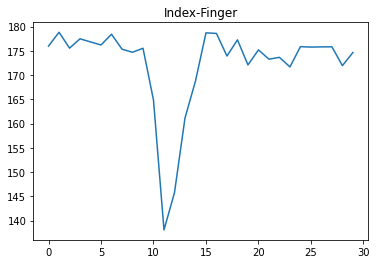

In [57]:
plotgrph(60,90)

In [58]:
my_dict1[0]=tempo[60:90]

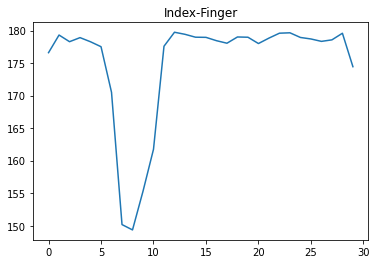

In [59]:
plotgrph(110,140)

In [60]:
my_dict1[1]=tempo[110:140]

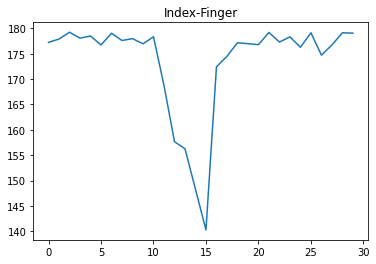

In [61]:
plotgrph(190,220)

In [62]:
my_dict1[2]=tempo[190:220]

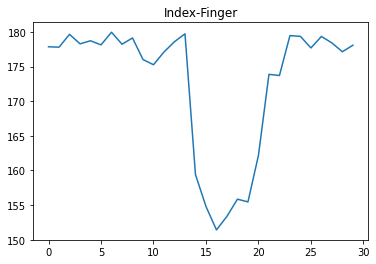

In [63]:
plotgrph(220,250)

In [64]:
my_dict1[3]=tempo[220:250]

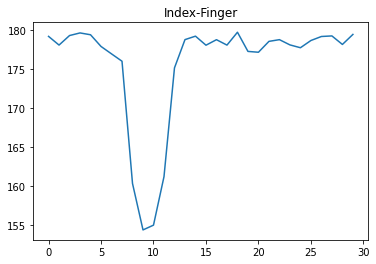

In [65]:
plotgrph(250,280)

In [66]:
my_dict1[4]=tempo[250:280]

In [27]:
my_dict1={0: [175.97483314820127,
  178.82622167449614,
  175.54576241081588,
  177.4724574545554,
  176.82887614028388,
  176.19860037024847,
  178.41432229804963,
  175.3326093992769,
  174.69360995066253,
  175.52750741742994,
  164.82277930125537,
  138.05855072219452,
  145.74246961678546,
  161.12243430291994,
  168.7571795428729,
  178.70119148595467,
  178.57916877223204,
  173.92278070197315,
  177.25567697351218,
  172.08699814601792,
  175.1866810216508,
  173.26866933747834,
  173.65176067751204,
  171.67579517974414,
  175.85481180212574,
  175.76613239202894,
  175.81121297595521,
  175.82099331197,
  171.94363285736233,
  174.6460265754753],
 1: [176.59503701694885,
  179.30620847505924,
  178.28146413574618,
  178.9072967723766,
  178.27023329218017,
  177.51166393946107,
  170.50384928987617,
  150.16615748385698,
  149.34596837683117,
  155.2876917753402,
  161.74175143187776,
  177.58316084915148,
  179.73482935516975,
  179.4167075712574,
  178.97366871260843,
  178.94982499366066,
  178.43644292170137,
  178.04822767761462,
  179.00752176362366,
  178.96785547732952,
  177.99885276422063,
  178.8335991999765,
  179.5885291489046,
  179.64971511866014,
  178.93190431291467,
  178.70121932678504,
  178.3312651398627,
  178.5645061637583,
  179.57901727026805,
  174.43928441533316],
 2: [177.2293355613292,
  177.88165504842715,
  179.22208609684773,
  178.06198246063482,
  178.48685898791612,
  176.71287623032705,
  179.02489129383542,
  177.5989182954374,
  177.96027931017082,
  176.93956410989003,
  178.33213074533472,
  168.73705141501284,
  157.64756528312992,
  156.26042558628566,
  148.26603337470914,
  140.26419890124092,
  172.41490587930278,
  174.47738976669638,
  177.1515221116793,
  176.9635470536393,
  176.77579225546913,
  179.18545743072403,
  177.29353962039139,
  178.30951171515065,
  176.2597656685776,
  179.11851977798338,
  174.7055399020152,
  176.71210264661372,
  179.12033413419687,
  179.03522433857194],
 3: [177.8679108211808,
  177.81195811805637,
  179.66537107186153,
  178.29104638652086,
  178.73748213669936,
  178.14425570424578,
  179.9677913960082,
  178.2365542069903,
  179.1405835245514,
  176.0270454150906,
  175.27460612335344,
  177.1162023371656,
  178.6020559358524,
  179.7413377485771,
  159.41412320413318,
  154.808564317444,
  151.4180965030209,
  153.38350574789234,
  155.85866964003188,
  155.46238108349857,
  162.18404157990338,
  173.88543101761644,
  173.72034725638505,
  179.48254246563388,
  179.3711900005293,
  177.70218881079285,
  179.36197376861338,
  178.42172913968847,
  177.15015959403337,
  178.09279854016322],
 4: [179.19562200464875,
  178.08103400274263,
  179.30389489511848,
  179.63860904675033,
  179.4041124573418,
  177.9032026613922,
  176.9509051023512,
  176.0061945415891,
  160.31679012695142,
  154.35675337230728,
  154.969350357254,
  161.1902217367932,
  175.15593740676167,
  178.7807121603907,
  179.224049075508,
  178.06330140649234,
  178.771282945577,
  178.07652943048782,
  179.7267640519802,
  177.26647420410058,
  177.1598744173451,
  178.55490127189606,
  178.77580351133207,
  178.10278348959918,
  177.73904471081278,
  178.66691987404823,
  179.18180219029963,
  179.2539116122786,
  178.1599232102858,
  179.44801052019602]}

In [67]:
my_dict1

{0: [175.97483314820127,
  178.82622167449614,
  175.54576241081588,
  177.4724574545554,
  176.82887614028388,
  176.19860037024847,
  178.41432229804963,
  175.3326093992769,
  174.69360995066253,
  175.52750741742994,
  164.82277930125537,
  138.05855072219452,
  145.74246961678546,
  161.12243430291994,
  168.7571795428729,
  178.70119148595467,
  178.57916877223204,
  173.92278070197315,
  177.25567697351218,
  172.08699814601792,
  175.1866810216508,
  173.26866933747834,
  173.65176067751204,
  171.67579517974414,
  175.85481180212574,
  175.76613239202894,
  175.81121297595521,
  175.82099331197,
  171.94363285736233,
  174.6460265754753],
 1: [176.59503701694885,
  179.30620847505924,
  178.28146413574618,
  178.9072967723766,
  178.27023329218017,
  177.51166393946107,
  170.50384928987617,
  150.16615748385698,
  149.34596837683117,
  155.2876917753402,
  161.74175143187776,
  177.58316084915148,
  179.73482935516975,
  179.4167075712574,
  178.97366871260843,
  178.94982499

In [53]:
##...........................LHS now.................

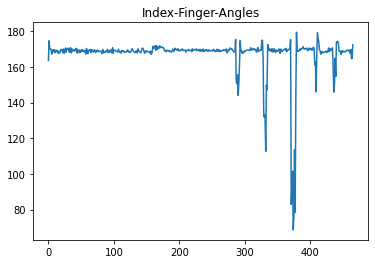

In [70]:
import matplotlib.pyplot as plt
t1=[i for i in range(len(angle_array100))]
plt.plot(t1, angle_array100)#X-Y axis
plt.title("Index-Finger-Angles")
#plt.savefig('T4a.png')
plt.show()

In [71]:
my_dict1b = {}
for i in range(5):
    my_dict1b[i] = [0] * 30

In [72]:
tempo=angle_array100.copy()

In [73]:
import matplotlib.pyplot as plt
def plotgrph(a,b):
    t1=[i for i in range(len(angle_array100[a:b]))]
    plt.plot(t1, angle_array100[a:b])#X-Y axis
    plt.title("Index-Finger")
    plt.show()

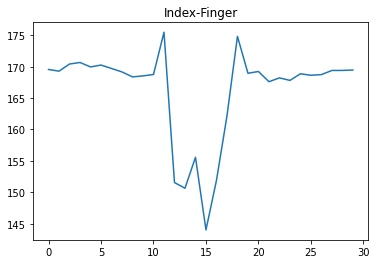

In [92]:
plotgrph(275,305)

In [93]:
my_dict1b[0]=tempo[275:305]

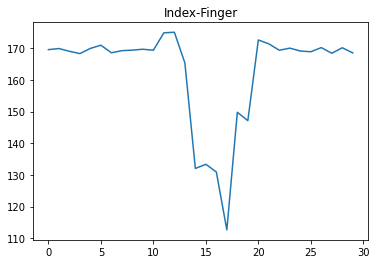

In [94]:
plotgrph(315,345)

In [95]:
my_dict1b[1]=tempo[315:345]

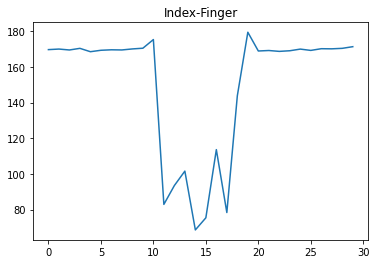

In [96]:
plotgrph(360,390)

In [97]:
my_dict1b[2]=tempo[360:390]

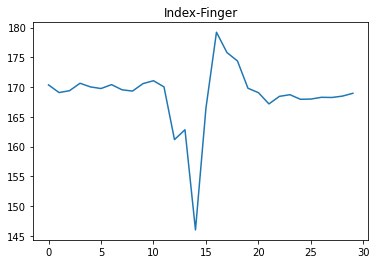

In [98]:
plotgrph(395,425)

In [99]:
my_dict1b[3]=tempo[395:425]

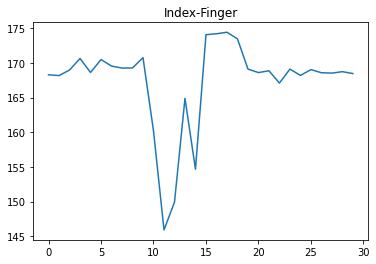

In [100]:
plotgrph(425,455)

In [101]:
my_dict1b[4]=tempo[425:455]

In [28]:
my_dict1b={0: [169.55116172472952,
  169.2861376908016,
  170.42193314921136,
  170.66689506644263,
  169.95887976846484,
  170.25903819026234,
  169.71456907772037,
  169.15993101852357,
  168.37100882910835,
  168.53030401928478,
  168.7547712392718,
  175.48170756317674,
  151.54608482648487,
  150.64354119852513,
  155.5752863429966,
  144.00689090810698,
  151.9011214097142,
  162.14198217124672,
  174.82512757609877,
  168.95154251765427,
  169.2299083734858,
  167.60698126930265,
  168.21282373261243,
  167.81389086546477,
  168.8697512584996,
  168.63093979287422,
  168.74061422617848,
  169.39774176949896,
  169.40195019668113,
  169.46539002282594],
 1: [169.55794254836965,
  169.90741648622054,
  169.03447822824106,
  168.306289390585,
  169.94333194238632,
  170.9514116478856,
  168.56941568546807,
  169.23747152348093,
  169.40326768086345,
  169.68363046249453,
  169.366123512573,
  174.86663321978418,
  175.0482664018059,
  165.38394512397528,
  132.04320821319527,
  133.37134796112275,
  130.93118393219504,
  112.64521859004404,
  149.78733672204865,
  147.14270824540807,
  172.60451036490792,
  171.38721118531907,
  169.36941014768283,
  170.0276324002422,
  169.12467631518476,
  168.89372278566648,
  170.19975399823613,
  168.40999965024218,
  170.1540789920306,
  168.51764248507052],
 2: [169.73223240677805,
  170.04867457458792,
  169.53288603423792,
  170.44694342341995,
  168.5658371814745,
  169.36405263118127,
  169.63492748330268,
  169.54655240574562,
  170.12346435732317,
  170.52299666476864,
  175.3765504458332,
  82.89071112762525,
  93.46112765044863,
  101.56111952464664,
  68.56444192302231,
  75.35641226872471,
  113.616832094698,
  78.31612151552417,
  143.83632472656967,
  179.48508806516548,
  168.96339481770147,
  169.2358116875727,
  168.7467709217328,
  169.10351681419118,
  170.0269838592659,
  169.2934782878027,
  170.24451350702145,
  170.18018106406646,
  170.4557949539651,
  171.3839286437505],
 3: [170.36789565235293,
  169.08440021222935,
  169.39804773673762,
  170.65015584929512,
  170.03205586055483,
  169.7636514201498,
  170.41724967295085,
  169.55101549232805,
  169.3324079748756,
  170.59095698846315,
  171.07291769895104,
  170.03595481150367,
  161.1735531899312,
  162.8285481199197,
  145.98391407613474,
  166.50529842485818,
  179.22910388851344,
  175.81249214938097,
  174.39941273694,
  169.810459737913,
  169.06662098908848,
  167.17794624191598,
  168.44586928159464,
  168.72588534523737,
  167.95426104231942,
  167.99045006104708,
  168.28728935755183,
  168.2570433941285,
  168.48709258095343,
  168.96440056127744],
 4: [168.27654651630453,
  168.1624515364148,
  168.96166235389836,
  170.63205298309683,
  168.60835169934873,
  170.47371938878385,
  169.5357224829025,
  169.24081674388793,
  169.26250336460376,
  170.75132215570522,
  160.18915044351792,
  145.9019466123207,
  149.89881332667886,
  164.87685932204866,
  154.6627469669959,
  174.05447451434983,
  174.19253310507807,
  174.41175704901784,
  173.45897247806678,
  169.0995153795601,
  168.59290193678086,
  168.8574976526684,
  167.0816750372291,
  169.0957199495247,
  168.17937437970005,
  169.02063564323038,
  168.5718391161603,
  168.51781304340935,
  168.72592131400845,
  168.4531404221213]}

In [102]:
my_dict1b

{0: [169.55116172472952,
  169.2861376908016,
  170.42193314921136,
  170.66689506644263,
  169.95887976846484,
  170.25903819026234,
  169.71456907772037,
  169.15993101852357,
  168.37100882910835,
  168.53030401928478,
  168.7547712392718,
  175.48170756317674,
  151.54608482648487,
  150.64354119852513,
  155.5752863429966,
  144.00689090810698,
  151.9011214097142,
  162.14198217124672,
  174.82512757609877,
  168.95154251765427,
  169.2299083734858,
  167.60698126930265,
  168.21282373261243,
  167.81389086546477,
  168.8697512584996,
  168.63093979287422,
  168.74061422617848,
  169.39774176949896,
  169.40195019668113,
  169.46539002282594],
 1: [169.55794254836965,
  169.90741648622054,
  169.03447822824106,
  168.306289390585,
  169.94333194238632,
  170.9514116478856,
  168.56941568546807,
  169.23747152348093,
  169.40326768086345,
  169.68363046249453,
  169.366123512573,
  174.86663321978418,
  175.0482664018059,
  165.38394512397528,
  132.04320821319527,
  133.371347961

In [53]:
##...........................

In [29]:
d1=my_dict1.copy()
d2=my_dict2.copy()
d3=my_dict3.copy()
d4=my_dict4.copy()
d5=my_dict1b.copy()

In [54]:
####..........................#####